In [1]:
# This code should load the dataframe and get corresponding results

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import statannot
from brokenaxes import brokenaxes
plt.rcParams['pdf.fonttype']=42

In [3]:
import pandas as pd

In [4]:
# Set up plotting

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
lets = list('bcdefghijklmnopqrstuv')
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(-.1, 1.1, lets[i], weight='bold', transform=ax.transAxes)
        # ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(constrained_layout=True, figsize=(12, 16))
gs = GridSpec(3, 9, figure=fig)
plt.rcParams['font.family'] = 'Arial'

<Figure size 1200x1600 with 0 Axes>

In [5]:
import numpy as np

In [6]:
np.random.seed(1337) # Set random seed.

In [7]:
def bootstrap(x, lengths=None, B=2000, metric=np.mean, multlens=False):
    """
    Bootstrap function
    
    x = list of error rates
    lengths = what the length of each sentence is if you're doing wer
    B = number of samples to draw
    metric = function to use. if lengths is not None, then only mean is calculated
    multlens = multiply list of error rates by their lengths, otherwise just take the mean. 
    """
    dist = []
    if lengths is None: 
        for _ in range(B):
            inds = np.random.choice(np.arange(len(x)), size=len(x), replace=True)
            x_=x[inds]
            dist.append(metric(x_))
    else: 
        for _ in range(B):
            inds = np.random.choice(np.arange(len(x)), size=len(x), replace=True)
            x_ = x[inds]
            ls = lengths[inds]
            if multlens: 
                dist.append(np.nansum(x_*ls)/np.nansum(ls))
            else: 
                
                dist.append(np.nansum(x_)/np.nansum(ls))
   
    return dist


def parceled_error_rates(vals, lengths=None, metric=np.mean, parcelation=10):

    """
    Calculate error rates in blocks of 10
    Has the case for nan - e.g. for the one trial that was discarded, since it was
    present in the training data by accident. 
    
    If the length of the list is larger than half the parcelation size, we allow it to be 
    used as a block. In practice this was not used for this paper.
    """
    dist = []
    cur_list = []
    cur_lengths = []
    if lengths is None: 
        lengths = np.ones((len(vals)))
    for k, x in enumerate(vals):
        cur_list.append(x)
        if pd.isna(x): 
            cur_lengths.append(np.nan)
        else: 
            cur_lengths.append(lengths[k])
        if (k+1)%parcelation == 0: 
            dist.append(np.nansum(np.array(cur_list)*np.array(cur_lengths))/np.nansum(np.array(cur_lengths)))
            cur_list = []
            cur_lengths = []
    if len(cur_list) > parcelation/2: 
        dist.append(np.nansum(np.array(cur_list)*np.array(cur_lengths))/np.nansum(np.array(cur_lengths)))
    return np.array(dist)
        
def return_distribution(lom, lengths=None, metric=np.mean):
    """
    Input : list of metrics - basically just like a list, we want to change it to be median and stuff. 
    """
    return parceled_error_rates(lom, lengths)

def pseudoblock(values, metric,  lengths_df =None, lengths=None):
    """
    Get the corresponding length from length dataframe to calculate the pseudoblock-wise metric. 
    The length dataframe has the ground truth sent, ground truth phones, 
    and corresponding lengths in number of words, chars, and phones. 
    
    Note single-trial PER ignored the first silence token to avoid artificially inflating performance. 
    """
    if lengths is None: 
        metric = metric.lower()
        if metric == "WER".lower():
            lengths = lengths_df['word'].values
        elif metric == 'CER'.lower():
            lengths = lengths_df['chars'].values
        elif metric =='PER'.lower():
            lengths = lengths_df['phones'].values
        else: 
            print('no metric')
            lengths = np.ones(len(values)) # Using this instead of lengths just averages.
    return return_distribution(values, np.array(lengths))

lengths_df = pd.read_hdf('./ground_truth_lengths.h5')

In [8]:
import matplotlib as mpl
def plotting_defaults(font='Arial', fontsize=11, linewidth=1):
    # Set some plotting colors and styles
    mpl.rcParams.update({'font.size': fontsize})
    # mpl.rcParams['font.sans-serif'] = [font]
    mpl.rcParams['axes.spines.top'] = False
    mpl.rcParams['axes.spines.right'] = False
    mpl.rcParams['xtick.major.size'] = 5
    mpl.rcParams['xtick.major.width'] = linewidth
    mpl.rcParams['ytick.major.size'] = 5
    mpl.rcParams['ytick.major.width'] = linewidth
    mpl.rcParams['lines.linewidth'] = linewidth
    mpl.rcParams['axes.linewidth'] = linewidth

plotting_defaults()

In [9]:
sns.set_palette('Set2')

In [10]:
def translate_labels(df):
    """
    Make the labels look good.
    """
    conds = df['Condition'].values
    newconds = []
    for c in conds: 
        if c == 'No beam, no LM':
            c = 'Neural\ndecoding\nonly'
        elif c =='No LM':
            c = '+Beam\nsearch\n& lexicon'
        elif c == 'Realtime results':
            c = 'Real-time\nresults'
        newconds.append(c)
    df['Condition'] = newconds
    return df

In [11]:
resdf = pd.read_hdf('./decodes_and_error_rates.h5')
resdf.head()

,Condition,WER,CER,PER,gts,trans,gtphs
0,Realtime results,0.166667,0.137931,0.160000,just look at all those people,she look at all those people,"[|, JH, AH, S, T, |, L, UH, K, |, AE, T, |, AO..."
1,Realtime results,0.000000,0.000000,0.000000,i will see what i can do,i will see what i can do,"[|, AY, |, W, IH, L, |, S, IY, |, W, AH, T, |,..."
2,Realtime results,0.571429,0.482759,0.423077,only when i give you an order,only when i could be a boy,"[|, OW, N, L, IY, |, W, EH, N, |, AY, |, G, IH..."
3,Realtime results,0.000000,0.000000,0.000000,i just got out here,i just got out here,"[|, AY, |, JH, AH, S, T, |, G, AA, T, |, AW, T..."
4,Realtime results,0.666667,0.633333,0.629630,if anything ever happens to me,i have to me,"[|, IH, F, |, EH, N, IY, TH, IH, NG, |, EH, V,..."


In [12]:
wers = np.array(resdf['WER'])
cers = np.array(resdf['CER'])
pers = np.array(resdf['PER'])

# Make the bad trial NAN
# This was a single trial we threw out because the sentence was mistakenly in the training data. 
# And we wanted to evaluate performance on unseen sentences. 
for i in (resdf.loc[resdf['gts'] == 'you have a request'].index): 
    wers[i] = np.nan
    cers[i] = np.nan
    pers[i] = np.nan
    
resdf['WER'] = wers
resdf['CER'] = cers
resdf['PER'] = pers

In [13]:
resdf.head()

,Condition,WER,CER,PER,gts,trans,gtphs
0,Realtime results,0.166667,0.137931,0.160000,just look at all those people,she look at all those people,"[|, JH, AH, S, T, |, L, UH, K, |, AE, T, |, AO..."
1,Realtime results,0.000000,0.000000,0.000000,i will see what i can do,i will see what i can do,"[|, AY, |, W, IH, L, |, S, IY, |, W, AH, T, |,..."
2,Realtime results,0.571429,0.482759,0.423077,only when i give you an order,only when i could be a boy,"[|, OW, N, L, IY, |, W, EH, N, |, AY, |, G, IH..."
3,Realtime results,0.000000,0.000000,0.000000,i just got out here,i just got out here,"[|, AY, |, JH, AH, S, T, |, G, AA, T, |, AW, T..."
4,Realtime results,0.666667,0.633333,0.629630,if anything ever happens to me,i have to me,"[|, IH, F, |, EH, N, IY, TH, IH, NG, |, EH, V,..."


In [14]:
resdf_to_share = resdf.loc[resdf['Condition'] == 'Realtime results']
resdf_to_share = pd.DataFrame({'Ground Truth':resdf_to_share['gts'], 'Transcription':resdf_to_share['trans'], 
                               'WER':resdf_to_share['WER'], 'CER':resdf_to_share['CER'], 'PER':resdf_to_share['PER']})

In [15]:
resdf_to_share.to_csv('./results_and_error_rates.csv')

In [16]:
resdf.iloc[96]

Condition                                     Realtime results
WER                                                        NaN
CER                                                        NaN
PER                                                        NaN
gts                                         you have a request
trans                                    you have a girlfriend
gtphs        [|, Y, UW, |, HH, AE, V, |, AH, |, R, IH, K, W...
Name: 96, dtype: object

In [17]:
ax1 = fig.add_subplot(gs[0, :3])
resdf.head()
resdf = translate_labels(resdf)
np.sum([pd.isna(w) for w in resdf['WER'].values])

3

In [18]:
len(resdf)

750

In [19]:
(set(resdf['Condition'].values))

{'Chance', 'Neural\ndecoding\nonly', 'Real-time\nresults'}

In [20]:
sdf = resdf.loc[resdf['Condition'] == 'Real-time\nresults']

In [21]:
def getlengths(lengths_df, val): 
    if val == 'WER': 
        return lengths_df['word'].values
    elif val == 'CER': 
        return lengths_df['chars'].values
    elif val == 'PER': 
        return lengths_df['phones'].values

In [22]:
for val in ['WER', 'CER', 'PER']:
    sdf = resdf.loc[resdf['Condition'] == 'Neural\ndecoding\nonly']
    lengths = getlengths(lengths_df, val)
    print(val, ['%.3f' %p for p in np.percentile(bootstrap(pseudoblock(sdf[val].values, val, lengths_df)), [.5, 50, 99.5])])

WER ['0.540', '0.590', '0.633']
CER ['0.480', '0.522', '0.562']
PER ['0.263', '0.294', '0.328']


In [23]:
for val in ['PER']:
    sdf = resdf.loc[resdf['Condition'] == 'Neural\ndecoding\nonly']
    lengths = getlengths(lengths_df, val)
#     print(val, np.percentile(bootstrap(pseudoblock(sdf[val].values, val, lengths_df)), [.5, 50, 99.5]))
    print(val, ['%.3f' %p for p in np.percentile(bootstrap(pseudoblock(sdf[val].values, val, lengths_df)), [.5, 50, 99.5])])
    print(np.percentile(bootstrap(pseudoblock(sdf[val].values, val, lengths_df), metric=np.mean), [.5, 50, 99.5]))
    print('%.3f' %np.median(bootstrap(pseudoblock(sdf[val].values, val, lengths_df), metric=np.mean)))

PER ['0.260', '0.294', '0.329']
[0.26341036 0.29362259 0.3262206 ]
0.294


In [24]:
sdf = resdf.loc[resdf['Condition'] == 'Chance']
val = 'PER'
lengths = getlengths(lengths_df, val)
print(val, np.percentile(bootstrap(pseudoblock(sdf[val].values, val, lengths_df)), [.5, 50, 99.5]))
print('%.3f' %np.median(pseudoblock(sdf[val].values, val, lengths_df)))

PER [0.75112205 0.76351713 0.77467366]
0.769


In [25]:
print('REPORTED IN PAPER')
for val in ['WER', 'CER', 'PER']:
    sdf = resdf.loc[resdf['Condition'] == 'Real-time\nresults']
    lengths = getlengths(lengths_df, val)
    v = pseudoblock(sdf[val].values, val, lengths_df)
    print(np.median(v))
    print(val, ['%.3f' %p for p in np.percentile(bootstrap(v, metric=np.median),  [.5, 50, 99.5])], '%.3f' %np.median(v))

REPORTED IN PAPER
0.2549019607843137
WER ['0.193', '0.255', '0.345'] 0.255
0.19907407407407407
CER ['0.150', '0.199', '0.301'] 0.199
0.1845765793134214
PER ['0.141', '0.185', '0.285'] 0.185


In [26]:
lildf = resdf.loc[resdf['Condition'] =='Real-time\nresults']
lildf.head()
wers = lildf['WER'].values

In [27]:
from statannot import add_stat_annotation

In [28]:
wer, cer, per, cond = [], [], [], []
for c in set(resdf['Condition'].values):
    sdf = resdf.loc[resdf['Condition'] == c]
    for metric, metlist in zip(['WER', 'CER', 'PER'], [wer, cer, per]):
        dvs = pseudoblock(np.array(sdf[metric].values), metric, lengths_df)
        metlist.extend([100*k for k in dvs ])
    cond.extend([c]*len(dvs))
len(cond), len(wer)

(75, 75)

In [29]:
resdf = pd.DataFrame({
    'Condition':cond,
    'WER':wer,
    'CER':cer,
    'PER':per
})

In [30]:
resdf.loc[resdf['Condition'] == 'Neural\ncdecoding\nonly']["WER"] = None
resdf.loc[resdf['Condition'] == 'Chance']['WER'] = None
resdf.loc[resdf['Condition'] == 'Neural\ncdecoding\nonly']["CER"] = None
resdf.loc[resdf['Condition'] == 'Chance']['CER'] = None

/tmp/ipykernel_384485/2763137870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resdf.loc[resdf['Condition'] == 'Chance']['WER'] = None
/tmp/ipykernel_384485/2763137870.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resdf.loc[resdf['Condition'] == 'Chance']['CER'] = None


In [31]:
# bootstrapped_wers= bootstrap(wers, lengths= lengths_df['word'].values, multlens=True)
# print(np.mean(bootstrapped_wers), np.median(bootstrapped_wers))

In [32]:
def plot_components(ax1, y, y_name):
    if y == 'PER':
        order= ['Chance', 'Neural\ndecoding\nonly', 'Real-time\nresults']
        box_pairs=[("Chance", "Real-time\nresults"), ("Neural\ndecoding\nonly", "Real-time\nresults"), ("Chance", "Neural\ndecoding\nonly")]
    else: 
        order =['Chance', 'Real-time\nresults']
        box_pairs=[("Chance", "Real-time\nresults")]
    bps = box_pairs
    resdf_ = resdf.loc[resdf['Condition'].isin(order)]
    sns.boxplot(x='Condition', y=y, data=resdf_,
                order=order,
               ax=ax1, medianprops=dict(linewidth=1.25),
                **{'boxprops':{'facecolor':'none'}})
    ax1.set_ylabel(y_name)
    x = 'Condition'
    y=y
    # Note - because all p-values < .0001 after correction (see below, we just keep this as is) 
    test_results = add_stat_annotation(ax1, data=resdf_, x=x, y=y, order=order,
                                       box_pairs = bps,
                                       test='Wilcoxon', text_format='star',
                                       loc='outside', verbose=2, linewidth=1)
    ax1.set_xlabel('')

In [33]:
from scipy.stats import wilcoxon

In [34]:
from statsmodels.stats.multitest import multipletests

In [35]:
def get_pvalues(df, metrics):
    p_values = []
    just_p_values = []
    for y in metrics: 
        if y == 'PER':
            order= ['Chance', 'Neural\ndecoding\nonly', 'Real-time\nresults']
            box_pairs=[("Chance", "Real-time\nresults"), ("Neural\ndecoding\nonly", "Real-time\nresults"), ("Chance", "Neural\ndecoding\nonly")]
        else: 
            order =['Chance', 'Real-time\nresults']
            box_pairs=[("Chance", "Real-time\nresults")]
        bps = box_pairs
        resdf_ = resdf.loc[resdf['Condition'].isin(order)]
        for (b1, b2) in box_pairs: 
            print(b1, b2)
            x_vals = resdf_.loc[resdf_['Condition'] == b1][y].values
            y_vals = resdf_.loc[resdf_['Condition'] == b2][y].values
            w= wilcoxon(x_vals, y_vals)
            p_values.append((y+' '+b1.replace('\n', ' ') + ' vs. ' + b2.replace('\n', ' '), w))
            just_p_values.append(w.pvalue)
            
#     print(just_p_values)
    correction = multipletests(just_p_values, alpha=0.01, method='holm')[1]
    test, pcor, praw, name = [], [], [], []
    for v, d in zip(p_values, correction):
        name.append(v[0])
        test.append(v[1].statistic)
        praw.append(v[1].pvalue)
        pcor.append(d)
    df = pd.DataFrame({
        'Comparison': name,
        'statistic': test,
#         'raw p-value':praw,
        'p-value (corrected)':pcor
    })
    return df

In [36]:
ps = get_pvalues(resdf, ['PER', 'WER', 'CER'])

Chance Real-time
results
Neural
decoding
only Real-time
results
Chance Neural
decoding
only
Chance Real-time
results
Chance Real-time
results


In [37]:
print(ps.to_latex(index=False, float_format="{:0.2e}".format))

\begin{tabular}{lrr}
\toprule
                                    Comparison &  statistic &  p-value (corrected) \\
\midrule
              PER Chance vs. Real-time results &   0.00e+00 &             2.98e-07 \\
PER Neural decoding only vs. Real-time results &   0.00e+00 &             2.98e-07 \\
           PER Chance vs. Neural decoding only &   0.00e+00 &             2.98e-07 \\
              WER Chance vs. Real-time results &   0.00e+00 &             2.98e-07 \\
              CER Chance vs. Real-time results &   0.00e+00 &             2.98e-07 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_384485/1210041412.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ps.to_latex(index=False, float_format="{:0.2e}".format))


In [38]:
# ax1.set_xticklabels(order, rotation = 90)
plot_components(ax1, 'PER', "Phone error rate")
ax1.set_ylim([0, 110])
ax1.spines['left'].set_bounds(0, 100)
ax1.set_yticks([0, 25, 50, 75, 100])
ax1b = fig.add_subplot(gs[0, 3:5])
plot_components(ax1b, 'WER', "Word error rate")
ax1b.set_ylim([0, 110])
ax1b.spines['left'].set_bounds(0, 100)
ax1b.set_yticks([0, 25, 50, 75, 100])
ax1c = fig.add_subplot(gs[0, 5:7])
ax1c.spines['left'].set_bounds(0, 100)
plot_components(ax1c, 'CER', "Character error rate")
ax1c.set_ylim([0, 110])
ax1c.set_yticks([0, 25, 50, 75, 100])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
nc 3
num comp 3
Neural
decoding
only v.s. Real-time
results: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.788e-07 stat=0.000e+00
Using zero_method  wilcox
nc 3
num comp 3
Chance v.s. Neural
decoding
only: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.788e-07 stat=0.000e+00
Using zero_method  wilcox
nc 3
num comp 3
Chance v.s. Real-time
results: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.788e-07 stat=0.000e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
nc 1
num comp 1
Chance v.s. Real-time
results: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.960e-08 stat=0.000e+00
p-v

<Figure size 640x480 with 0 Axes>

### Words per minute...

In [39]:
# Words/minute. 
ax1d = fig.add_subplot(gs[0, -2:])
df=pd.read_hdf('./wpms.h5')
wpms_all = df['wpm'].values[:250] # 
wpms_all[96] = np.nan
wpms_all = pseudoblock(wpms_all, metric = 'WPM')

nudf = pd.DataFrame({
    'Words per minute':wpms_all,
    'Condition':['Real-time\nresults']*len(wpms_all)
})
# nudf.to_csv('./source_data/figure_2e.csv')
sns.boxplot(x='Condition', y='Words per minute', data=nudf, width=0.4, ax=ax1d, color=sns.color_palette('Set2')[3],
            medianprops = dict(linewidth=1.25),
            **{'boxprops':{'facecolor':'none'}})
ax1d.axhline(15, label='Moses et al 2021', c='k', alpha=.8, linestyle='--')

# ax1d.legend()
ax1d.set_ylim(0, 90)
ax1d.set_xlabel('')
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))

no metric


Text(0.5, 0, '')

In [40]:
help(bootstrap)

Help on function bootstrap in module __main__:

bootstrap(x, lengths=None, B=2000, metric=<function mean at 0x7f2a200abca0>, multlens=False)
    Bootstrap function
    
    x = list of error rates
    lengths = what the length of each sentence is if you're doing wer
    B = number of samples to draw
    metric = function to use. if lengths is not None, then only mean is calculated
    multlens = multiply list of error rates by their lengths, otherwise just take the mean.



In [41]:
wpms_all = np.array(wpms_all)

In [42]:
np.median(wpms_all), np.percentile(bootstrap(np.array(wpms_all)), [0.5, 99.5])

(78.25899141367181, array([75.39320561, 79.48518814]))

In [43]:
# np.max(wpms_all), np.percentile(bootstrap(wpms_all, metric=np.max), [0.5, 99.5])

In [44]:
df = pd.read_hdf('./ground_truth_lengths.h5')

In [45]:
df.head()

,word,chars,phones,gt,gtphs
0,6,29,26,just look at all those people,"[|, JH, AH, S, T, |, L, UH, K, |, AE, T, |, AO..."
1,7,24,23,i will see what i can do,"[|, AY, |, W, IH, L, |, S, IY, |, W, AH, T, |,..."
2,7,29,27,only when i give you an order,"[|, OW, N, L, IY, |, W, EH, N, |, AY, |, G, IH..."
3,5,19,19,i just got out here,"[|, AY, |, JH, AH, S, T, |, G, AA, T, |, AW, T..."
4,6,30,28,if anything ever happens to me,"[|, IH, F, |, EH, N, IY, TH, IH, NG, |, EH, V,..."


### Learning curve. 

In [46]:
ax2 = fig.add_subplot(gs[1, :3])
import seaborn as sns
sns.set_palette(sns.color_palette('Set2'))
import matplotlib
# sdf = pd.read_hdf('./learning_curve_data.h5')

In [47]:
sdf = pd.read_hdf('./learning_curve_data.h5')

In [48]:
days = []
score = []
metric= []
for k, w, p, c in zip(sdf['days_to_use'], sdf['rt_med_wer'], sdf['rt_med_per'], sdf['rt_med_cer']):

#     score.extend([w, p, c])
#     metric.extend(['Word', 'Phoneme', 'Character'])


    import ast
    w = ast.literal_eval(w)
    p = ast.literal_eval(p)
    c = ast.literal_eval(c)

    w[96] = np.nan
    p[96] = np.nan
    c[96]= np.nan
    score.extend(pseudoblock(w, 'wer', lengths_df))
    score.extend(pseudoblock(p, 'per', lengths_df))
    score.extend(pseudoblock(c, 'cer', lengths_df))
    days.extend((3*len(pseudoblock(c, 'cer', lengths_df)))*[k])
    metric.extend(['Word']*len(pseudoblock(w, 'wer', lengths_df)) + ['Phoneme']*len(pseudoblock(p, 'per', lengths_df)) + ['Character']*len(pseudoblock(c, 'cer', lengths_df)))
# wer, cer, per, cond = [], [], [], []
# for c in set(resdf['Condition'].values):
#     sdf = resdf.loc[resdf['Condition'] == c]
#     for metric, metlist in zip(['WER', 'CER', 'PER'], [wer, cer, per]):
        
#         metlist.extend(return_distribution(sdf[metric].values))
#     cond.extend([c]*len(sdf[metric].values))
    

# len(cond), len(wer)

# resdf = pd.DataFrame({
#     'Condition':cond,
#     'WER':wer,
#     'CER':cer,
#     'PER':per
# })



In [49]:
nudf = pd.DataFrame({
    'Days of data collection\n(Hours of training data used)':days,
    'Error rate':score,
    'Metric':metric,
})

In [50]:
set(days)

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0}

In [51]:
set(metric)

{'Character', 'Phoneme', 'Word'}

In [52]:
# Cut out duplicate trials

In [53]:
days_, score_, metric_ = [],[], []

In [54]:
for d in list(set(days)): 
    sdf = nudf.loc[nudf['Days of data collection\n(Hours of training data used)'] ==d]
    for metric in ['Word', 'Phoneme', 'Character']: 
        sdf_ = sdf.loc[sdf['Metric'] == metric]
        days_.extend([d]*125)
        score_.extend(sdf_['Error rate'].values[-125:]) # Use last CV runs
        metric_.extend([metric]*125)

In [55]:
len(days_), len(score_)

(4875, 4875)

In [56]:
nudf = pd.DataFrame({
    'Days of data collection\n(Hours of training data used)':days_,
    'Error rate':score_,
    'Metric':metric_,
})

In [57]:
# sns.lineplot(x='Days of data collection\n(Hours of training data used)', y='Error rate', hue='Metric',style='Metric', markers=True,dashes=True,
#             data=nudf, err_style='bars', alpha=0.7,estimator='median')

In [58]:
sns.lineplot(x='Days of data collection\n(Hours of training data used)', y='Error rate', hue='Metric',style='Metric', markers=True,dashes=True,
            data=nudf, err_style='bars', alpha=0.7, ax=ax2, estimator='median', errorbar=('ci', 99))

<AxesSubplot: xlabel='Days of data collection\n(Hours of training data used)', ylabel='Error rate'>

In [59]:
# list(np.arange(10)/10)[::2]

In [60]:
# sns.set(rc={"lines.linewidth": 3})
# sns.lineplot(x='days_to_use', y='rt_med_wer', data=sdf, label='Word', err_style ='bars', estimator='median', ax=ax2,color=sns.color_palette('Set2')[4], 
#              markers="o", alpha=0.3) # linestyles='solid')
# sns.lineplot(x='days_to_use', y='rt_med_per', data=sdf, label='Phoneme', err_style='bars', estimator='median', ax=ax2, color=sns.color_palette('Set2')[5], 
#              markers='*', alpha=0.3) #, linestyles='solid')
# g= sns.lineplot(x='days_to_use', y='rt_med_cer', data=sdf, label='Character', err_style='bars', estimator='median', ax=ax2,
#                  color=sns.color_palette('Set2')[6], markers='h', alpha=0.3) #,linestyles='dashed')
# plt.setp([ax2.get_children()],alpha=.5)
ax2.set_yticks([0, .25, .5, .75, 1.0], [0, 25, 50, 75, 100])
ax2.legend()
ax2.grid(b=True, which='major', axis='y', color='black', linewidth=0.075)
ax2.set_xlabel('Days of data collection\n(Hours of training data used)')
ax2.set_ylabel('Error rate')
ax2.set_xticks(np.array([1, 5, 10, 13]),['1\n(1.6hr)', '5\n(7.4hr)', '10\n(15.5hr)', '13\n(17.7hr)'])

/tmp/ipykernel_384485/2695293292.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=True, which='major', axis='y', color='black', linewidth=0.075)


### Vocab

In [61]:
import pandas as pd
vocab_df =pd.read_hdf('./plot_vocab.h5')
set(vocab_df['Vocab size'].values)

{1024, 1506, 2269, 3419, 5152, 7763, 11696, 17621, 26549, 39378}

In [62]:
ax = fig.add_subplot(gs[1, 3:6])
vocab_df =pd.read_hdf('/userdata/smetzger/repos/b3_paper/fig2/plot_vocab.h5')
vocab_df = vocab_df.loc[vocab_df['Metric'] == 'WER']
vocab_df['WER'] = vocab_df['Error rate']

In [63]:
print(set(vocab_df['Vocab size']))

# vocab_df = vocab_df.loc[vocab_df['Vocab size'].isin([ 1024, 2000, 5000, 10000, 20000, 36464])]
vocab_df['Vocabulary size (words)'] = vocab_df['Vocab size']

# vocab_df.to_csv('./source_data/figure_2g.csv')
sns.lineplot(x='Vocabulary size (words)', y='WER', data=vocab_df, ax=ax, markers=True, dashes=True, estimator='median', err_style='bars', marker='o')
ax.semilogx()
ax.grid(b=True, which='major', axis='y', color='black', linewidth=0.075)
ax.set_yticks([0, .25, .5, .75, 1.0], [0, 25, 50, 75, 100])
ax.set_ylabel('Word error rate')
sns.despine()
# plt.savefig('./vocab_plot.png', dpi=300)

{1024, 5152, 1506, 11696, 39378, 7763, 17621, 26549, 3419, 2269}


/tmp/ipykernel_384485/2333622159.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', axis='y', color='black', linewidth=0.075)


<Figure size 640x480 with 0 Axes>

In [64]:
subplotspec = gs[1, 7:]

### NATO stabillity

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

# Loading
df = pd.read_hdf('./nato.hdf')

# df.to_csv('./figure_2h.csv')
t = df['Days since implantation'].values
y = df['NATO alphabet classification accuracy'].values

# Broken-axis simulation adjustment
cutoff     = 90
adjustment = 50

mod_mask = (t >= cutoff)
mod_inds = np.where(mod_mask)[0]
t_mod = t.copy()
t_mod[mod_inds] -= adjustment

first_mod_ind = mod_inds[0]
broken_midpoint = np.mean([t_mod[first_mod_ind - 1], t_mod[first_mod_ind]])

# Plotting
ax = fig.add_subplot(gs[1, 6:])
ax.plot(t_mod, y, '.', markersize=10, color='k', alpha=0.8)

# Formatting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

xlim = (25., 75.)
ax.set_xlim(*xlim)
ax.set_xlabel('Days after implantation')
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=5))

ax.set_ylabel('NATO code-word\nclassification accuracy (%)')
ax.set_ylim(0, 103)
ax.grid(b=True, which='major', axis='y', alpha=0.2)

# Chance accuracy
ax.axhline(100. / 30, alpha=0.3, linestyle='--', color='k')
ax.text(28, 6, 'Chance\naccuracy')

# Classifier freeze
ax.axvline(x=40.5, alpha=0.3, zorder=-2, linestyle='-', color='k')
ax.text(40.2, 45, 'Classifier\nfrozen')

# Adjusting x-tick labels for the modification
xticks = ax.get_xticks()
xticklabels = []
for i, cur_x_tick in enumerate(xticks):
    if cur_x_tick > broken_midpoint:
        cur_x_tick += adjustment
    xticklabels.append(str(int(cur_x_tick)))
ax.set_xticklabels(xticklabels, rotation=45)

# Blocks out portion of the x-axis to mimic a broken axis
broken_midpoint_ax_transform = (broken_midpoint - xlim[0]) / (xlim[1] - xlim[0])
ax.add_patch(plt.Rectangle(
    xy=(broken_midpoint_ax_transform - 0.02, -0.015), width=0.04, height=0.03,
    edgecolor=None, facecolor="white", zorder=1e10, clip_on=False, transform=ax.transAxes
))

# Plots the diagonal lines to mimic a broken axis
line_scale = 0.025
line_kwargs = dict(lw=1., transform=ax.transAxes, color='k', clip_on=False, zorder=1e10)
for cur_shifts in ((-0.027, -0.013), (0.013, 0.027)):
    ax.plot(broken_midpoint_ax_transform + np.array(cur_shifts), (-0.02, 0.02), **line_kwargs)

/tmp/ipykernel_384485/1343185630.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', axis='y', alpha=0.2)
/tmp/ipykernel_384485/1343185630.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels, rotation=45)


In [66]:
d = pd.read_hdf('./nato.hdf')

In [67]:
d.head()

,Days since implantation,NATO alphabet classification accuracy
0,27,67.307692
1,28,84.615385
2,29,61.538462
3,29,73.076923
4,30,69.230769


In [68]:
d = d.loc[d['Days since implantation'] > 40]

In [69]:
np.mean(d['NATO alphabet classification accuracy'])

96.76113360323887

In [70]:
np.sum(d['NATO alphabet classification accuracy'].values == 100)

8

In [71]:
len(d)

19

In [72]:
np.diff(d['Days since implantation'].values)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1, 61,  0,  1,
        2])

In [73]:
def bootstrap(x, lengths=None, B=2000, metric=np.mean, multlens=False):
#     assert metric == np.mean
    dist = []
    if lengths is None: 
        for _ in range(B):
            inds = np.random.choice(np.arange(len(x)), size=len(x), replace=True)
            x_=x[inds]
            dist.append(metric(x_))
    else: 
        for _ in range(B):
            inds = np.random.choice(np.arange(len(x)), size=len(x), replace=True)
            x_ = x[inds]
            ls = lengths[inds]
            if multlens: 
                dist.append(np.sum(x_*ls)/np.sum(ls))
            else: 
                
                dist.append(np.sum(x_)/np.sum(ls))
    return dist
f = d['NATO alphabet classification accuracy'].values
print(np.percentile(bootstrap(f, lengths=None, B=2000, metric=np.mean), (.5, 50, 99.5)))

[94.73684211 96.7611336  98.3805668 ]


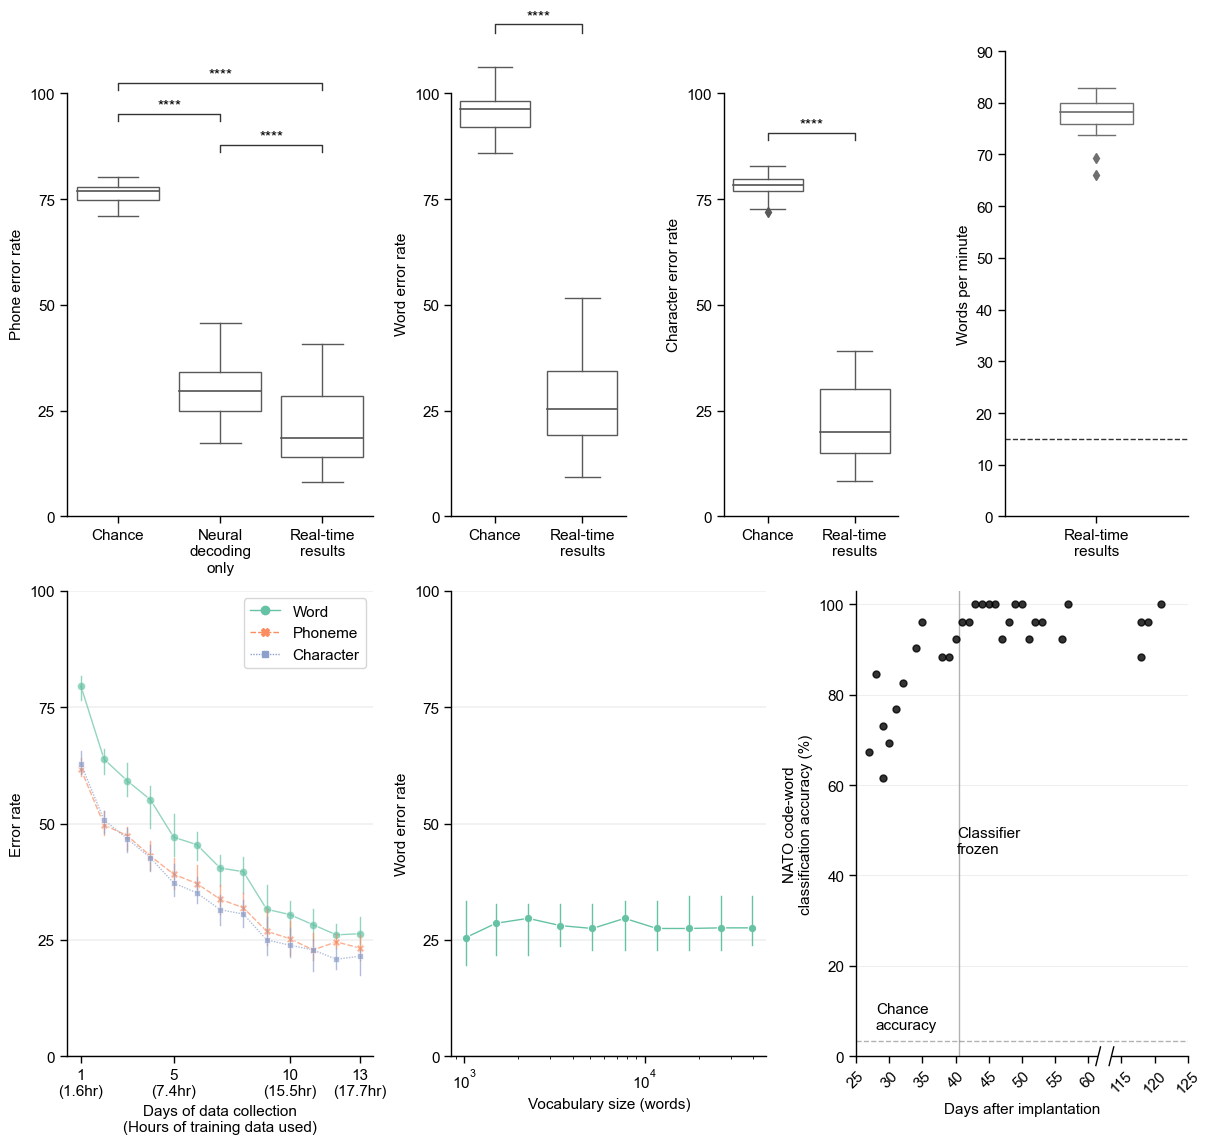

In [74]:
fig